## Overview

Detecting Anomalies can be a difficult task and especially in the case of labeled datasets due to some level of human bias introduced while labeling the final product as anomalous or good. These giant manufacturing systems need to be monitored every 10 milliseconds to capture their behavior which brings in lots of information and what we call the Industrial IoT (IIOT). Also, hardly a manufacturer wants to create an anomalous product. Hence, the anomalies are like a needle in a haystack which renders the dataset that is significantly Imbalanced. 

Capturing such a dataset using a machine learning model and making the model generalize can be fun. In this competition, we bring such a use-case from one of India's leading manufacturers of wafers(semiconductors). The dataset collected was anonymized to hide the feature names, also there are 1558 features that would require some serious domain knowledge to understand them. 

### Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

### Data Analysis and Data Processing

In [2]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB


As we can see that this is a high dimensionality dataset. Let's drop the duplicate columns.

In [4]:
duplicate=df.drop('Class',axis=1).T.drop_duplicates().T.columns
Class = df['Class']
df_test = df_test[duplicate]
df = df[duplicate]
df['Class'] = Class

Let's check again.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 730 entries, feature_1 to Class
dtypes: float64(1), int64(729)
memory usage: 9.8 MB


Almost half of the columns were just duplicates. We just have half of the columns remained. Keeping the duplicate columns would have let to a less interpretable and slower model.

In [6]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


On looking at the data carefully we can see that only 'feature_1', 'feature_2', and 'feature_3' columns are numerical. All others are binary. Let's analyze the numerical columns.

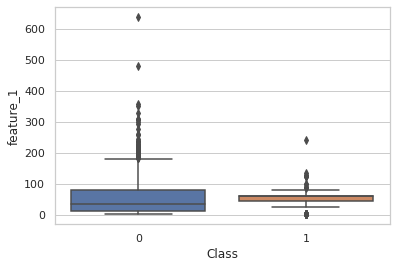

In [7]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="Class", y="feature_1",data=df)

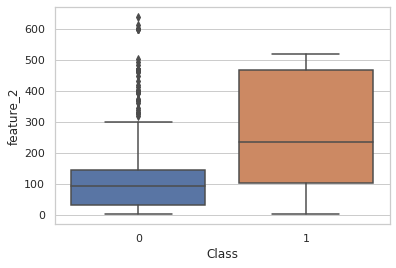

In [8]:
ax = sns.boxplot(x="Class", y="feature_2",data=df)

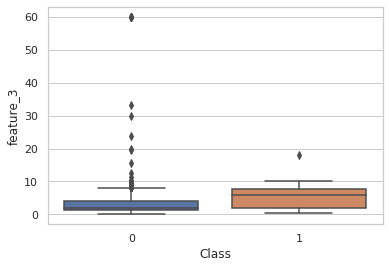

In [9]:
ax = sns.boxplot(x="Class", y="feature_3",data=df)

In [10]:
pd.DataFrame(df[['feature_1','feature_2','feature_3','Class']].corr()['Class'])


,Class
feature_1,0.006458
feature_2,0.330720
feature_3,0.108288
Class,1.000000


Let's work more eliminating useless features. Let's check if there are any columns which only consists of zeroes.

In [11]:
zero = pd.DataFrame((df == 0).astype(int).sum(axis=0))

In [12]:
zero

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,486
feature_5,1758
...,...
feature_1554,1756
feature_1555,1736
feature_1557,1746
feature_1558,1761


This dataframe gives us the number of zeroes every feature has. So out of 1763 values if a column has 1762 or 1763 zeroes itself than it is a pretty bad feature as the model won't be able to capture any pattern out if it. So let's drop them.

In [13]:
all_zero = zero[zero[0]>1761].index

In [14]:
df.drop(all_zero,axis=1,inplace=True)

In [15]:
df_test.drop(all_zero,axis=1,inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 723 entries, feature_1 to Class
dtypes: float64(1), int64(722)
memory usage: 9.7 MB


So now we have now successfully removed 7 more useless features

### Model Building

In [17]:
X = df.drop('Class',axis=1)
y = df['Class'].values

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


As it is a very high dimensional dataset it is very easy to overfit. That's why hyperparameter tuning played a huge role. Let's go in-depth with some of the hyperparameters:

scale_pos_weight : To counter the imbalanced nature of the dataset

colsample_bytree, subsample, reg_lambda : To counter overfitting

In [30]:
from xgboost import XGBClassifier

model = XGBClassifier(silent=True,
                      booster = 'gbtree',
                      scale_pos_weight=5,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.5,
                      max_delta_step = 3,
                      reg_lambda = 2,
                     objective='binary:logistic',
                      
                      n_estimators=818, 
                      max_depth=8,
                     )

eval_set = [(X_test, y_test)]
eval_metric = ["logloss"]
%time model.fit(X_train, y_train,early_stopping_rounds=50, eval_metric=eval_metric, eval_set=eval_set)


[0]	validation_0-logloss:0.686058
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.679579
[2]	validation_0-logloss:0.672846
[3]	validation_0-logloss:0.666644
[4]	validation_0-logloss:0.659762
[5]	validation_0-logloss:0.653567
[6]	validation_0-logloss:0.64726
[7]	validation_0-logloss:0.640943
[8]	validation_0-logloss:0.635053
[9]	validation_0-logloss:0.629305
[10]	validation_0-logloss:0.623016
[11]	validation_0-logloss:0.617321
[12]	validation_0-logloss:0.61172
[13]	validation_0-logloss:0.605567
[14]	validation_0-logloss:0.59997
[15]	validation_0-logloss:0.594569
[16]	validation_0-logloss:0.58909
[17]	validation_0-logloss:0.584022
[18]	validation_0-logloss:0.579084
[19]	validation_0-logloss:0.573959
[20]	validation_0-logloss:0.56946
[21]	validation_0-logloss:0.564486
[22]	validation_0-logloss:0.559631
[23]	validation_0-logloss:0.554953
[24]	validation_0-logloss:0.55024
[25]	validation_0-logloss:0.546004
[26]	validation_0-logloss:0.541487
[27

[230]	validation_0-logloss:0.232794
[231]	validation_0-logloss:0.23265
[232]	validation_0-logloss:0.232392
[233]	validation_0-logloss:0.231759
[234]	validation_0-logloss:0.231323
[235]	validation_0-logloss:0.231205
[236]	validation_0-logloss:0.230806
[237]	validation_0-logloss:0.230385
[238]	validation_0-logloss:0.229649
[239]	validation_0-logloss:0.229294
[240]	validation_0-logloss:0.229053
[241]	validation_0-logloss:0.228945
[242]	validation_0-logloss:0.228487
[243]	validation_0-logloss:0.228236
[244]	validation_0-logloss:0.227905
[245]	validation_0-logloss:0.227676
[246]	validation_0-logloss:0.227609
[247]	validation_0-logloss:0.227438
[248]	validation_0-logloss:0.226701
[249]	validation_0-logloss:0.226428
[250]	validation_0-logloss:0.226145
[251]	validation_0-logloss:0.225863
[252]	validation_0-logloss:0.225631
[253]	validation_0-logloss:0.22518
[254]	validation_0-logloss:0.224852
[255]	validation_0-logloss:0.224537
[256]	validation_0-logloss:0.224326
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.199499
[460]	validation_0-logloss:0.19948
[461]	validation_0-logloss:0.19952
[462]	validation_0-logloss:0.199754
[463]	validation_0-logloss:0.199681
[464]	validation_0-logloss:0.19991
[465]	validation_0-logloss:0.199818
[466]	validation_0-logloss:0.199969
[467]	validation_0-logloss:0.199967
[468]	validation_0-logloss:0.199805
[469]	validation_0-logloss:0.199978
[470]	validation_0-logloss:0.199662
[471]	validation_0-logloss:0.199387
[472]	validation_0-logloss:0.199239
[473]	validation_0-logloss:0.199313
[474]	validation_0-logloss:0.199194
[475]	validation_0-logloss:0.198906
[476]	validation_0-logloss:0.199048
[477]	validation_0-logloss:0.199135
[478]	validation_0-logloss:0.199269
[479]	validation_0-logloss:0.199215
[480]	validation_0-logloss:0.19936
[481]	validation_0-logloss:0.199517
[482]	validation_0-logloss:0.199336
[483]	validation_0-logloss:0.199295
[484]	validation_0-logloss:0.19921
[485]	validation_0-logloss:0.199335
[486]	validation_0-logloss:0.1993

XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_delta_step=3,
              max_depth=8, min_child_weight=0, n_estimators=818, reg_lambda=2,
              scale_pos_weight=5, silent=True, subsample=0.5)

### Model Evaluation

In [31]:
predictions = model.predict_proba(X_test)[:,-1]

In [32]:
roc_auc_score(y_test, predictions)

0.9367207715831569

So we are getting an auc score of 0.93!!

### Feature Importance

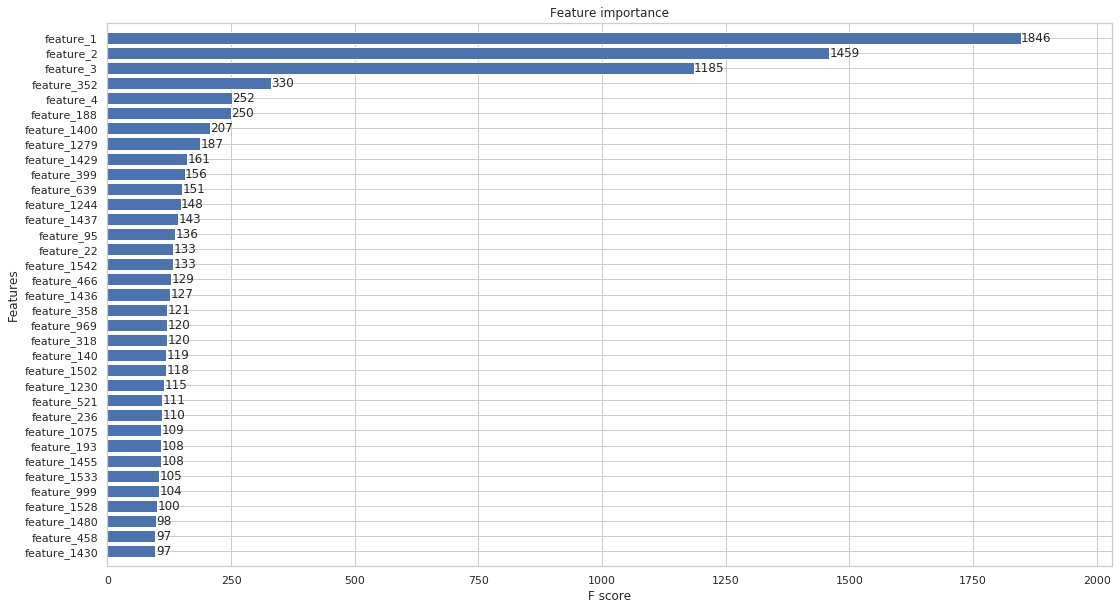

In [34]:
import matplotlib.pyplot as plt     
model.feature_importances_
from matplotlib import pyplot
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(18,10))
plot_importance(model, max_num_features=35, height=0.8, ax=ax)
pyplot.show()

### Making Predictions and Submitting the results

In [22]:
p1 = model.predict_proba(df_test)[:,-1]
submission = pd.DataFrame(p1)
submission = submission.rename(columns={0: "Class"})
submission.index = submission['Class']
submission.drop('Class',axis=1,inplace=True)
submission.to_csv('submissiom.csv',header=True, index=True)